In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [102]:
engine.execute('select * from Measurement').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0),
 (21, 'USC00519397', '2010-01-23', 0.0, 67.0),
 (22, 'USC00519397

# Exploratory Climate Analysis

In [20]:
engine.execute('select * from Station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [23]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01',)

In [26]:
# Latest Date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

In [100]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                filter(Measurement.date > '2016-08-23').\
                group_by(Measurement.date).limit(10).all()
last_12_months

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05)]

In [70]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_scores = pd.DataFrame(last_12_months, columns=['Date', 'Precipitation'])

#prcp_scores = prcp_scores.sort_index(ascending = True)
#prcp_scores.set_index('Date', inplace=True)
#prcp_scores
prcp_scores.set_index('Date')
prcp_scores =prcp_scores.sort_index(ascending = True)
prcp_scores.head()


,Date,Precipitation
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


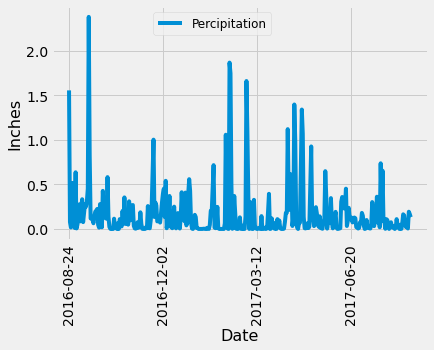

In [80]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_scores.plot('Date','Precipitation')
#ax= prcp_scores.plot.bar(figsize=(10,8), width=20)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Inches", fontsize=16)
#ax.set_xticklabels([])
plt.legend(['Percipitation'], fontsize=12)
ax.get_legend().set_bbox_to_anchor((0.6, 1))
plt.xticks(rotation = 90)
plt.show()

In [92]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sum_stat = prcp_scores["Precipitation"].describe()
sum_stat = pd.DataFrame(sum_stat)
sum_stat


,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [98]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Measurement.station).distinct().count()
print('Total number of stations is: {}'.format(total_stations))

Total number of stations is: 9


In [105]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,
                  func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()
for station in active_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
